# Akshay




In [11]:
# -*- coding: utf-8 -*-
"""Task5_Modified.ipynb
# Akshay S
"""

# ============================
# 📦 Import Required Libraries
# ============================
!pip install pandas scikit-learn nltk matplotlib seaborn

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords

In [12]:
# ============================
# 🧩 Step 1: Load Dataset
# ============================

# Download only first 50,000 rows for faster performance
dataset = pd.read_csv(
    "https://files.consumerfinance.gov/ccdb/complaints.csv.zip",
    compression="zip",
    low_memory=False,
    nrows=50000
)

# Retain only relevant columns
dataset = dataset[['Consumer complaint narrative', 'Product']].dropna()

# Map specific categories to numeric labels
label_dict = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

# Filter only selected categories
dataset = dataset[dataset['Product'].isin(label_dict.keys())]
dataset['Category'] = dataset['Product'].map(label_dict)

# Sample balanced dataset
balanced_data = (
    dataset.groupby('Category', group_keys=False)
    .apply(lambda grp: grp.sample(min(len(grp), 1500), random_state=42))
)

balanced_data.to_csv("consumer_complaints_balanced.csv", index=False)
print("✅ Dataset ready! Category distribution:")
print(balanced_data['Category'].value_counts())

✅ Dataset ready! Category distribution:
Category
0    463
1    347
3    106
2      8
Name: count, dtype: int64


/tmp/ipython-input-3240990962.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(min(len(grp), 1500), random_state=42))


In [13]:
# ============================
# 🧹 Step 2: Text Cleaning
# ============================
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    filtered = [w for w in text.split() if w not in stop_words]
    return " ".join(filtered)

balanced_data['cleaned_text'] = balanced_data['Consumer complaint narrative'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# ============================
# 🔀 Step 3: Train-Test Split
# ============================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    balanced_data['cleaned_text'],
    balanced_data['Category'],
    test_size=0.2,
    random_state=42,
    stratify=balanced_data['Category']
)


In [15]:
# ============================
# 🧠 Step 4: TF-IDF Vectorization
# ============================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_raw)
X_test_vec = vectorizer.transform(X_test_raw)
print("TF-IDF feature matrix shape:", X_train_vec.shape)

TF-IDF feature matrix shape: (739, 5000)


In [16]:
# ============================
# 🤖 Step 5: Model Training
# ============================
log_model = LogisticRegression(max_iter=300)
log_model.fit(X_train_vec, y_train)


LogisticRegression(max_iter=300)

In [17]:
# ============================
# 📊 Step 6: Evaluation
# ============================
y_pred = log_model.predict(X_test_vec)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Model Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    target_names=['Credit Reporting', 'Debt Collection', 'Consumer Loan', 'Mortgage']
))



✅ Model Accuracy: 0.7622

Classification Report:

                  precision    recall  f1-score   support

Credit Reporting       0.71      0.91      0.80        93
 Debt Collection       0.84      0.70      0.76        69
   Consumer Loan       0.00      0.00      0.00         2
        Mortgage       0.89      0.38      0.53        21

        accuracy                           0.76       185
       macro avg       0.61      0.50      0.52       185
    weighted avg       0.77      0.76      0.75       185



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


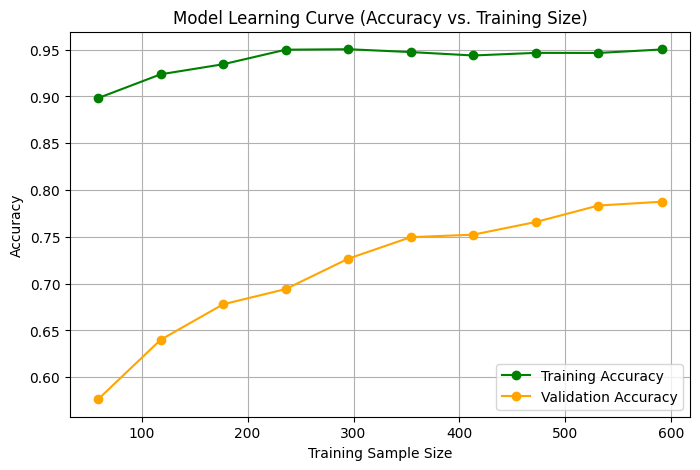

In [18]:

# ============================
# 📈 Step 7: Accuracy Graph
# ============================
train_sizes, train_scores, val_scores = learning_curve(
    log_model, X_train_vec, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color='green', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation Accuracy')
plt.title('Model Learning Curve (Accuracy vs. Training Size)')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [19]:

# ============================
# 🧪 Step 8: Prediction Test
# ============================
sample_texts = [
    "My credit report has wrong information even after I disputed it.",
    "The debt collector keeps calling me even after payment.",
    "The bank changed my mortgage rate without notice."
]

sample_preds = log_model.predict(vectorizer.transform(sample_texts))
print("Sample Predictions:", sample_preds)


Sample Predictions: [0 1 3]
